In [2]:
import os
import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split

In [3]:
print(tf.config.list_logical_devices('GPU'))

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [4]:
cat_dir = os.path.join(r"PetImages", "Cat")
dog_dir = os.path.join(r"PetImages", "Dog")

X, y = [], []
def load_images(folder, label):
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize((128, 128))
            X.append(np.array(img))
            y.append(label)
        except Exception as e:
            print(f"Failed to load image: {e}")

load_images(cat_dir, 0)
load_images(dog_dir, 1)

print(f"A total of, {len(X)} pictures have been uploaded.")

Failed to load image: cannot identify image file 'PetImages\\Cat\\666.jpg'
Failed to load image: cannot identify image file 'PetImages\\Cat\\Thumbs.db'
Failed to load image: cannot identify image file 'PetImages\\Dog\\11702.jpg'


c:\Users\natha\anaconda3\envs\cuda\lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Failed to load image: cannot identify image file 'PetImages\\Dog\\Thumbs.db'
A total of, 24998 pictures have been uploaded.


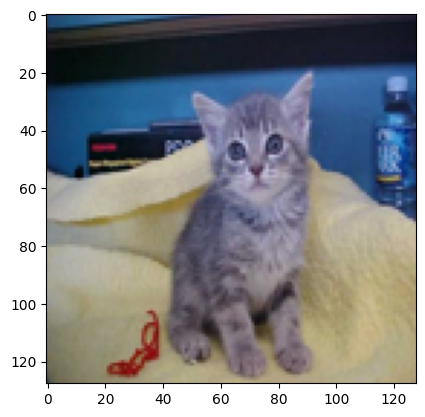

In [5]:
import matplotlib.pyplot as plt

plt.imshow(X[12400])
plt.show()

In [6]:
X = np.array(X, dtype='float32') / 255
y = np.array(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 17498, Testing samples: 7500


In [8]:
model = Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape = (128, 128, 3))) 
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.1))


model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(256,(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))


model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.15))

# Output layer
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',  patience=2,
                                            factor=0.5, min_lr = 0.00001, verbose = 1)
                                            

early_stopping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

In [10]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, learning_rate_reduction])

Epoch 1/30
547/547 [==============================] - 18s 24ms/step - loss: 0.6796 - accuracy: 0.6666 - val_loss: 0.8504 - val_accuracy: 0.5492 - lr: 0.0010
Epoch 2/30
547/547 [==============================] - 12s 22ms/step - loss: 0.4644 - accuracy: 0.7823 - val_loss: 0.4075 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 3/30
547/547 [==============================] - 12s 22ms/step - loss: 0.3741 - accuracy: 0.8337 - val_loss: 0.3475 - val_accuracy: 0.8496 - lr: 0.0010
Epoch 4/30
547/547 [==============================] - 12s 22ms/step - loss: 0.3063 - accuracy: 0.8676 - val_loss: 0.3846 - val_accuracy: 0.8225 - lr: 0.0010
Epoch 5/30
547/547 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.8840
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
547/547 [==============================] - 12s 22ms/step - loss: 0.2758 - accuracy: 0.8840 - val_loss: 0.3837 - val_accuracy: 0.8311 - lr: 0.0010
Epoch 6/30
547/547 [==============================] - 

In [18]:
with tf.device('/CPU:0'):
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
    
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

235/235 [==============================] - 2s 7ms/step - loss: 0.2029 - accuracy: 0.9243
Test Loss: 0.2029
Test Accuracy: 0.9243
